In [1]:
from importlib import reload
import numpy as np
import pandas as pd

import util
import metrics
import estimators.linear as linear_estimators
import estimators.mtr as mtr_estimators
import plotting

SEEDS = [100,101]

## Figure 1
The synthetic data was generated from a SWP distribution with Gaussian noise, and then a dataframe with ones was fitted to the data.

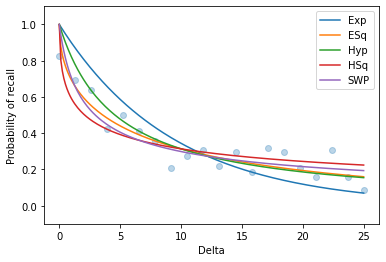

In [2]:
import matplotlib.pyplot as plt
reload(mtr_estimators)

np.random.seed(SEEDS[0])
def noisy_SWP(delta):
    delta = delta / (24*60*60)
    distribution_values = np.power((1+delta), -0.5)
    noise = np.random.normal(0, 0.1, len(delta), )
    return np.clip(distribution_values + noise, 0.0001, 0.999)

delta = np.linspace(0.00001, 25*24*60*60., 20)
df = pd.DataFrame({
    'delta': delta,
    'ones': np.ones(len(delta))
        }
    )
y = noisy_SWP(delta)

fitted_models = []

for estimator in mtr_estimators.all_estimators:
    model = estimator()
    model.fit(df, y, df['delta'])
    fitted_models.append(model)

delta_fit = np.linspace(0.00001, 25.*24*60*60, 200)
df_fit = pd.DataFrame({
    'delta': delta_fit,
    'ones': np.ones(len(delta_fit)
                   )
        }
    )
    
plt.scatter(delta/(24*60*60), y, alpha=0.3)
for model in fitted_models:
    if model.get_name() == 'HLR':
        continue
    name = model.get_name().strip('MTR-')
    plt.plot((delta_fit/(24*60*60)), model.predict(df_fit, df_fit['delta']), label = name)
    
plt.title('')
plt.ylim([-0.1, 1.1])
plt.xlabel("Delta", fontsize=10)
plt.ylabel("Probability of recall", fontsize=10)
plt.rcParams.update({
            'legend.fontsize': 10
        })
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 320
plt.legend()

## Table 2

The file 'learning_traces.13m.csv' must be in the same folder as this notebook and the accompanying library code. 

Download from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/N8XJME and decompress.

(In the paper, Linear Regression was omitted due to lack of space)

In [ ]:
from sklearn.model_selection import KFold, train_test_split
reload(metrics)
reload(linear_estimators)
reload(mtr_estimators)

duolingo_df = pd.read_csv('learning_traces.13m.csv')

y = duolingo_df['p_recall']
X = duolingo_df.drop(['p_recall', 'timestamp','user_id', 'learning_language', 'ui_language', 'lexeme_id', 'lexeme_string'], axis=1)

def cross_validate_duolingo_dataset(folds, seeds, estimator_constructor, dataset='all'):
    if dataset not in datasets:
        raise Exception(f"dataset must be one of {datasets}")
    
    if dataset=='only-delta':
        X_subset = X[['delta']]
    if dataset=='only-history':
        X_subset = X[['history_seen', 'history_correct']]
    if dataset=='only-session':
        X_subset = X[['session_seen', 'session_correct']]
    if dataset=='without-delta':
        X_subset = X[['session_seen', 'session_correct','history_seen', 'history_correct']]
    if dataset=='all':
        X_subset = X
    
    y_trues                = []
    y_preds                = []

    for seed in seeds:
        kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        for train_index, test_index in kf.split(X):
                                    
            X_train = X_subset.iloc[train_index]
            X_test  = X_subset.iloc[test_index]
            y_train = y.iloc[train_index]
            y_test  = y.iloc[test_index]
            delta_train = X['delta'].iloc[train_index]
            delta_test  = X['delta'].iloc[test_index]

            estimator = estimator_constructor()
            estimator.fit(X_train, y_train, delta_train)

            y_pred = estimator.predict(X_test, delta_test)
            y_pred = np.clip(y_pred, 0.000001, 0.999999)

            y_trues.append(y_test)
            y_preds.append(y_pred)

    return metrics.DuolingoEvaluation.from_CV(estimator.get_name(),
                                                y_trues, 
                                                y_preds, 
                                                dataset=dataset
                                             )



datasets =  'only-history', 'only-session', 'only-delta', 'without-delta', 'all'
evals = []
for estimator in [
    linear_estimators.LogisticRegressionEstimator,
    linear_estimators.LinearRegressionEstimator,
    mtr_estimators.HLRWithDeltaMTREstimator
]:
    for dataset in datasets:
        evaluation = cross_validate_duolingo_dataset(5, SEEDS, estimator, dataset=dataset)
        print(evaluation.to_latex_tabular_row())
        evals.append(evaluation)

In [ ]:
duolingo_df[duolingo_df['user_id']=='u:FO']

#### Lomb tables and figures

We first need to load the dataset:

In [33]:
reload(util)
X, y, previous_recall_score, df = util.load_data(users=['user_15'])
# X, y, previous_recall_score, df = util.load_data()


In [21]:
from collections import defaultdict

counter = defaultdict(int)

for log in util.load_logs():
    if 'user' in log:
        user = log['user']
        counter[user]+=1
print(counter)
    

defaultdict(<class 'int'>, {'user_1': 96260, 'user_2': 36361, 'user_3': 1181, 'user_4': 45, 'user_5': 23, 'user_6': 216, 'user_7': 47, 'user_8': 69, 'user_9': 352, 'user_10': 6, 'user_11': 8, 'user_12': 8, 'user_13': 1055, 'user_14': 334517, 'user_15': 38369, 'user_16': 213, 'user_17': 2, 'user_18': 4, 'user_19': 4})


## Figure 2


NameError: name 'duolingo_df' is not defined

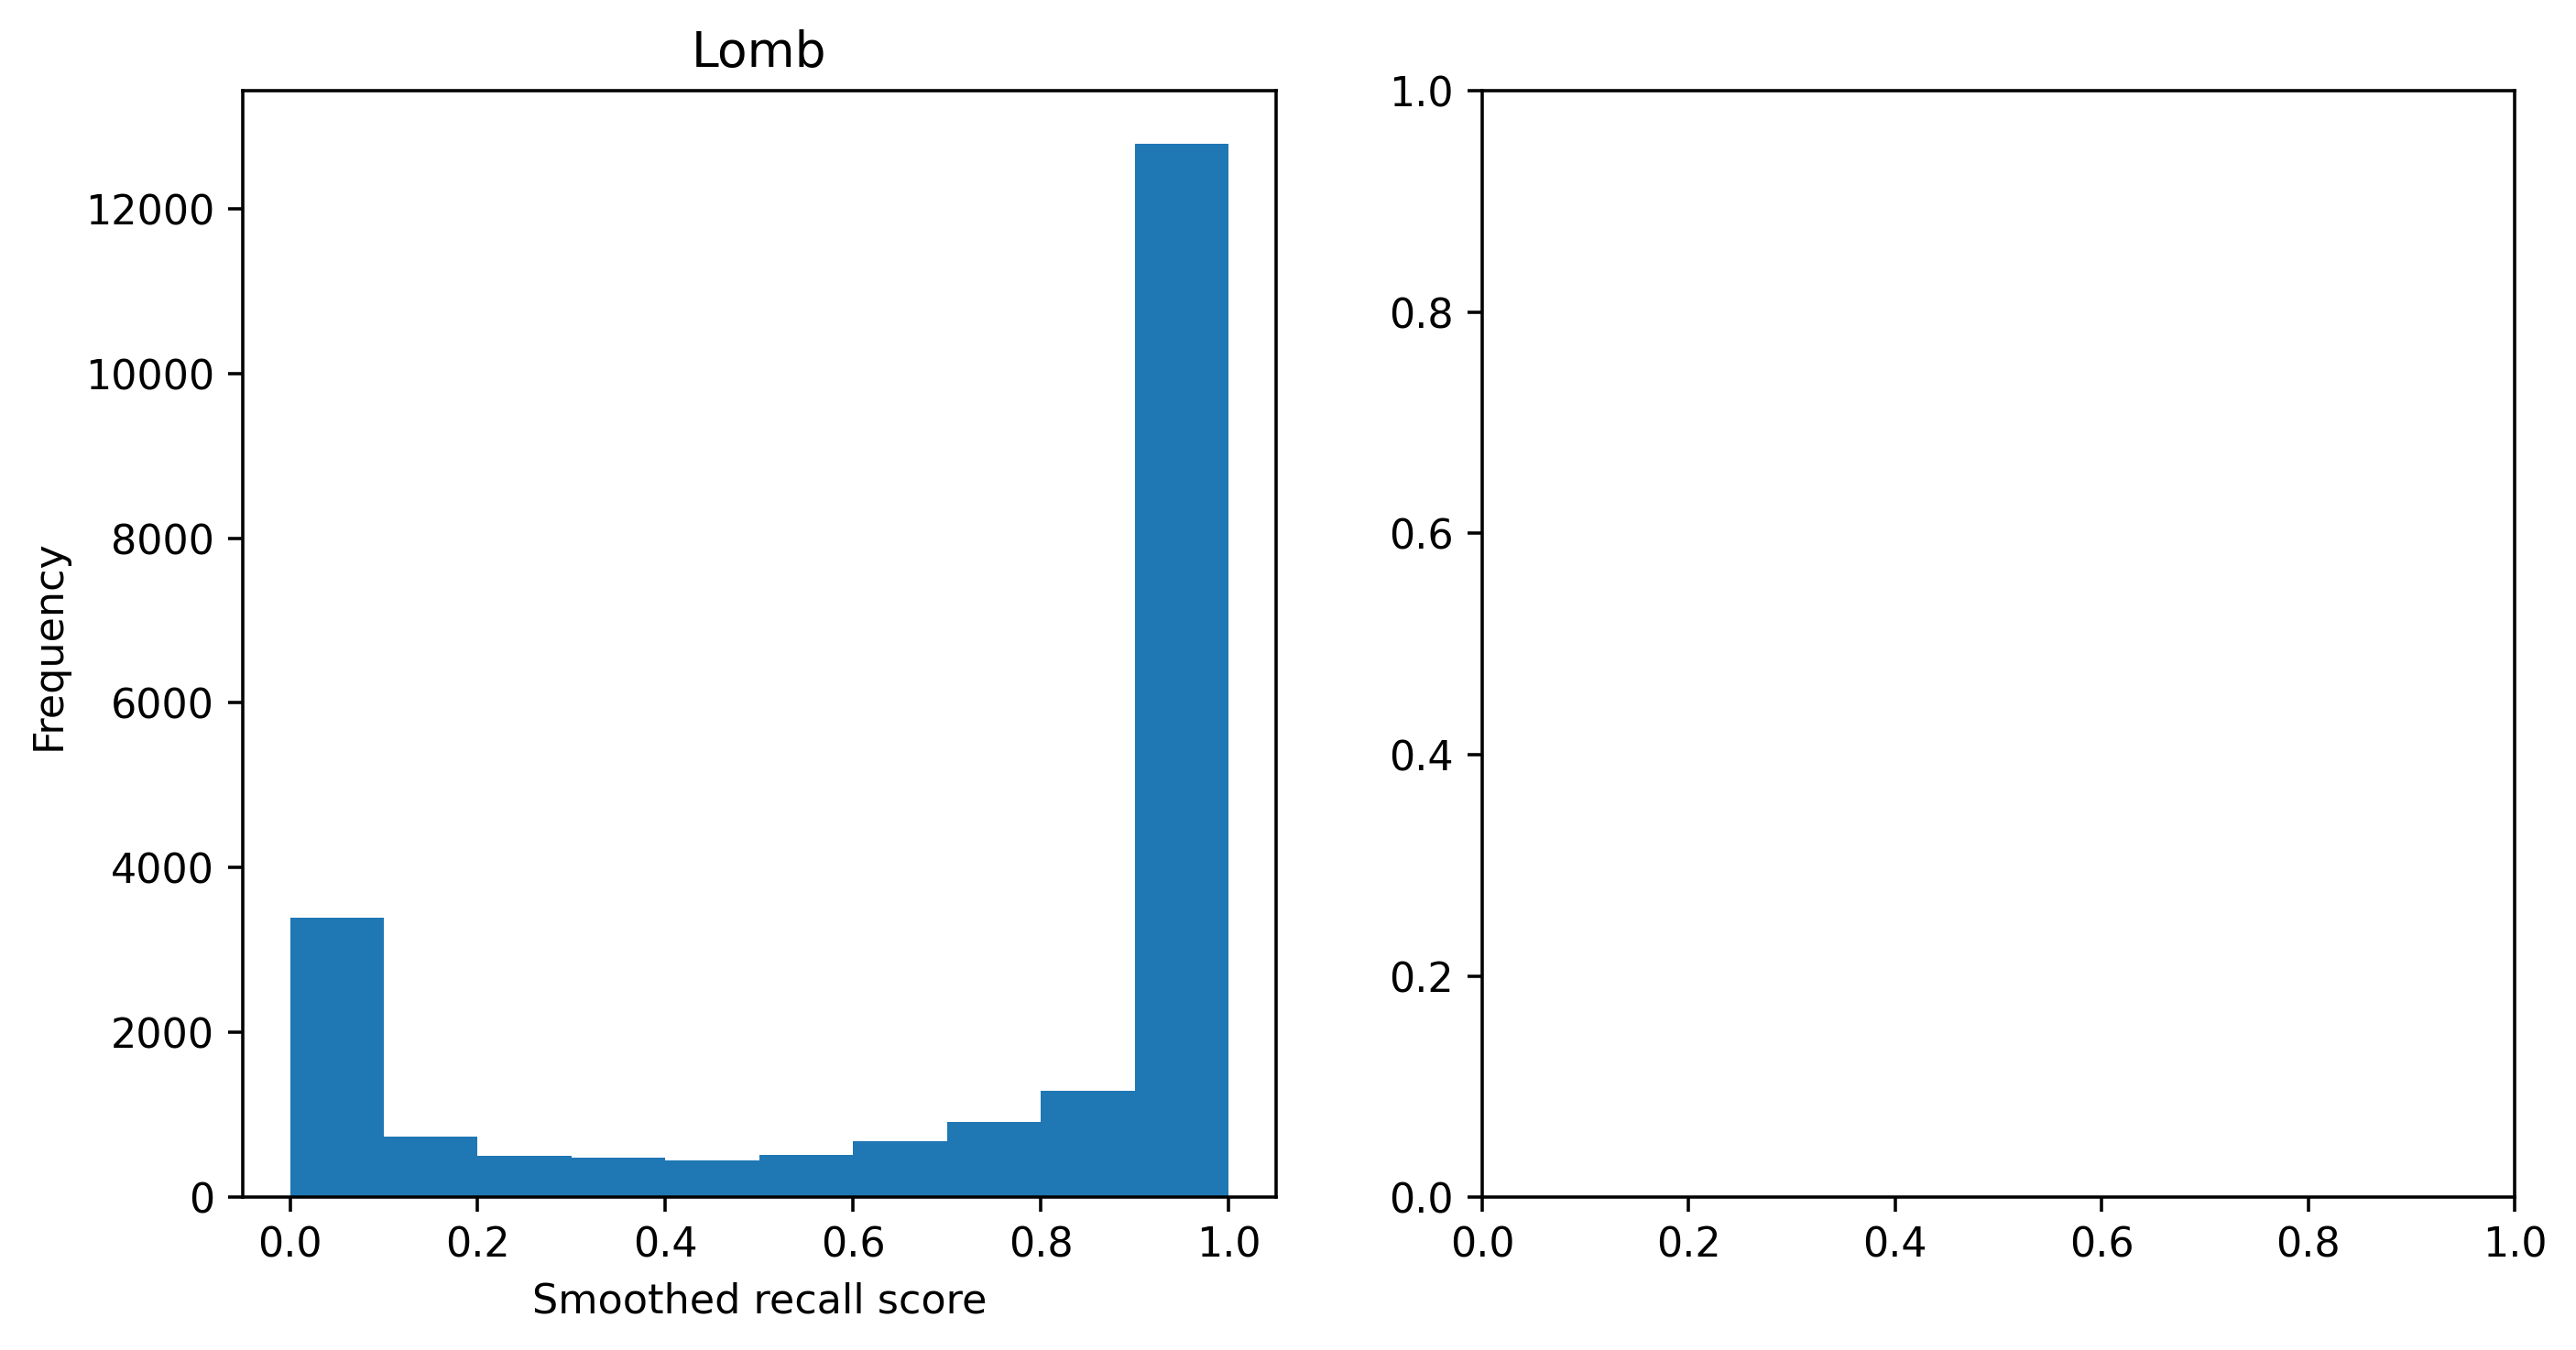

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

y.plot.hist(bins=10, ax=axes[0], title="Lomb")
axes[0].set_xlabel("Smoothed recall score")

duolingo_df['p_recall'].plot.hist(bins=10, title="Duolingo")
axes[1].set_xlabel("'p_recall'")


## Table 3
This presents the results of 5-fold, 2-pass CV on the Lomb dataset.

In [34]:
from sklearn.model_selection import KFold
import metrics
reload(metrics)
reload(mtr_estimators)
reload(linear_estimators)

estimator = None

def cross_validate_lomb_dataset(folds, seeds, estimator_constructor):
    global estimator
    
    y_trues                = []
    y_preds                = []
    previous_recall_scores = []
    deltas                 = []

    for seed in seeds:
        kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        for train_index, test_index in kf.split(X):

            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            X_test  = X.iloc[test_index]
            y_test  = y.iloc[test_index]
            delta_train = X['delta'].iloc[train_index]
            delta_test  = X['delta'].iloc[test_index]
            previous_recall_score_test = previous_recall_score.iloc[test_index]

            estimator = estimator_constructor()
            estimator.fit(X_train, y_train, delta_train)

            y_pred = estimator.predict(X_test, delta_test)
            y_pred = np.clip(y_pred, 0.000001, 0.999999)

            y_trues.append(y_test)
            y_preds.append(y_pred)
            previous_recall_scores.append(previous_recall_score_test)
            deltas.append(delta_test)
    return metrics.LombEvaluation.from_CV(estimator.get_name(),
                                                y_trues, 
                                                y_preds, 
                                                previous_recall_scores, 
                                                deltas)

for estimator in linear_estimators.all_estimators+mtr_estimators.all_estimators:
    print(cross_validate_lomb_dataset(5, SEEDS, estimator).to_latex_tabular_row())

Linear Regression & 0.102 & 0.0241 $\pm$ 0.015 & 0.00442 $\pm$ 0.0050 \\
Logistic Regression & 0.129 & 0.0473 $\pm$ 0.017 & 0.00592 $\pm$ 0.0049 \\


/home/.c/work/mtr/estimators/mtr.py:109: RuntimeWarning: overflow encountered in power
  exponent = np.divide(-1 * delta, np.power(2., mu))


HLR & 0.133 & 0.0182 $\pm$ 0.018 & 0.00519 $\pm$ 0.0094 \\


/home/.c/work/mtr/estimators/mtr.py:109: RuntimeWarning: overflow encountered in power
  exponent = np.divide(-1 * delta, np.power(2., mu))


HLR & 0.134 & 0.0183 $\pm$ 0.018 & 0.00520 $\pm$ 0.0094 \\
MTR-Exp & 0.183 & 0.0194 $\pm$ 0.014 & 0.00407 $\pm$ 0.0070 \\
MTR-ESq & 0.170 & 0.0209 $\pm$ 0.025 & 0.00408 $\pm$ 0.0070 \\
MTR-Hyp & 0.183 & 0.0190 $\pm$ 0.014 & 0.00413 $\pm$ 0.0072 \\
MTR-HSq & 0.171 & 0.0220 $\pm$ 0.027 & 0.00413 $\pm$ 0.0072 \\
MTR-SWP & 0.125 & 0.0174 $\pm$ 0.014 & 0.00408 $\pm$ 0.0070 \\


In [30]:
estimator

## Figure 3

In [12]:
mtr_swp = mtr_estimators.SWPMTREstimator()
mtr_swp.fit(X, y, X['delta'])

mtr_hlr = mtr_estimators.HLRMTREstimator()
mtr_hlr.fit(X, y, X['delta'])

linear_regression = linear_estimators.LinearRegressionEstimator()
linear_regression.fit(X, y, X['delta'])

logistic_regression = linear_estimators.LogisticRegressionEstimator()
logistic_regression.fit(X, y, X['delta'])


In [16]:
reload(plotting)
logs = util.load_logs()
plot_factory = plotting.PlotFactory(estimators = [
    plotting.EstimatorPlotDTO("MTR (SWP)",           "red",    mtr_swp), 
    plotting.EstimatorPlotDTO("HLR",                 "green",  mtr_hlr), 
    plotting.EstimatorPlotDTO("Logistic Regression", "orange", logistic_regression)
]
                                   )
plot_factory.config.add_time_after_last_timestamp = 30*24*60*60
plot_factory.config.interval_between_points       = 20*60*60
plot_factory.add_logs(logs)
top_lemmas_logs = plot_factory.top_lemmas(n=1000)
id_whitelist = ['charlie_dansk_skyde', 'charlie_zupfen']
logs_to_plot = filter(lambda id : id[0] in id_whitelist, top_lemmas_logs)
ids_to_plot = list(map(lambda id : id[0], logs_to_plot))
plot_factory.plot_many(ids_to_plot)

In [15]:
top_lemmas_logs

[('charlie_der', 10426),
 ('charlie_einen', 3486),
 ('charlie_dansk_på', 2476),
 ('charlie_dansk_have', 1808),
 ('charlie_dansk_som', 1389),
 ('charlie_im', 1206),
 ('charlie_nicht', 1131),
 ('charlie_dansk_en', 1081),
 ('charlie_dansk_så', 1066),
 ('charlie_dansk_min', 1030),
 ('charlie_dansk_den', 1002),
 ('charlie_dansk_blive', 885),
 ('charlie_dansk_vide', 860),
 ('charlie_dansk_skulle', 714),
 ('charlie_dansk_få', 685),
 ('charlie_ich', 649),
 ('charlie_dansk_være', 623),
 ('charlie_dansk_sige', 587),
 ('charlie_machen', 576),
 ('oliver-chao_y', 574),
 ('oliver-chao_de', 566),
 ('oliver-chao_lo', 558),
 ('charlie_dansk_se', 551),
 ('charlie_dansk_da', 548),
 ('charlie_dansk_sig', 544),
 ('charlie_dansk_og', 541),
 ('oliver-chao_uno', 530),
 ('charlie_dansk_i', 517),
 ('charlie_dansk_gå', 453),
 ('oliver-chao_el', 439),
 ('charlie_dansk_ind', 437),
 ('charlie_und', 435),
 ('charlie_dansk_Men', 428),
 ('oliver-chao_en', 423),
 ('charlie_dansk_nå', 413),
 ('charlie_dansk_til', 410),


Stuff I can do

General model for the year data
Individualized fits
Group by backtracking
Group by assessment test
